In [2]:
import numpy as np
import torch
import cv2

from lib.config.project_manager import ProjectManager
from lib.dataset.dataset2D import Dataset2D
from lib.hybridnet.efficienttrack.efficienttrack import EfficientTrack
import matplotlib.pyplot as plt

project = ProjectManager()
project.load('Example_Project')

#project.create_new(
#    name = 'Example_Project2',
#    dataset2D_path = 'Example_Dataset',
#    dataset3D_path = 'Example_Dataset')

cfg = project.get_cfg()

Successfully loaded project Example_Project!


In [3]:
#Load the training and validation sets

training_set = Dataset2D(project.cfg, set='train', mode = 'CenterDetect')
val_set = Dataset2D(project.cfg, set='val',mode = 'CenterDetect')

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [4]:
#Configuring the network for training

weights = 'pretrained/Monkey_Example/EfficientTrack_Center.pth'
centerDetect = EfficientTrack('CenterDetect', cfg, None)

Initializing weights...


In [5]:
#Training the network for 100 epochs

centerDetect.train(training_set, val_set, 100)

  0%|          | 0/789 [00:00<?, ?it/s]

TypeError: forward() takes 3 positional arguments but 4 were given

In [6]:
#Configuring the network for inference

weights = "pretrained/Monkey_Example/EfficientTrack_Center.pth"
centerDetect = EfficientTrack('CenterDetectInference', cfg, weights)

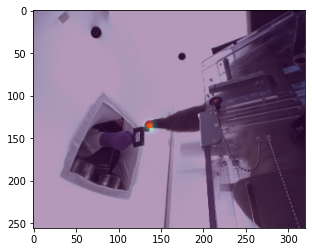

In [9]:
#Load item from validation set and show tracking result

item = val_set.__getitem__(4)
imgs = item[0]
preds, maxvals, img_vis, heatmap = centerDetect.predictCenter(imgs)
plt.imshow(img_vis/255.)
plt.imshow(heatmap, alpha=0.4)
plt.show()